__Change current directory__

In [1]:
import os
os.chdir('..')

### Import libraries and modules

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from timeit import default_timer
import pandas as pd
import seaborn as sns
from src import detector_descriptor as dd
from src import data as dt
from src import util
from src import experiments as ex
from src import imgop as ip
import yaml
plt.style.use('fast')


__Load configuration__

In [3]:
with open(os.path.join('./', 'config.yml'), 'r') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)
    cfg = cfg['default']

__Load image set__

In [4]:
dataset_path = cfg['dataset']['pckl_path']
dataset_pckl_name = cfg['dataset']['dataset_type']['oxford']['pckl_name']
pckl_path = os.path.join(dataset_path, dataset_pckl_name)

#### Image set to variance

In [5]:
image_set_variance = {
    'bark': 'zoom_rotation', 
    'boat': 'zoom_rotation',
    'leuven': 'light',
    'bikes': 'blur', 
    'trees': 'blur',
    'wall': 'viewpoint',
    'graf': 'viewpoint',
    'ubc': 'jpeg-compression'
}



##### Show all images from an image set

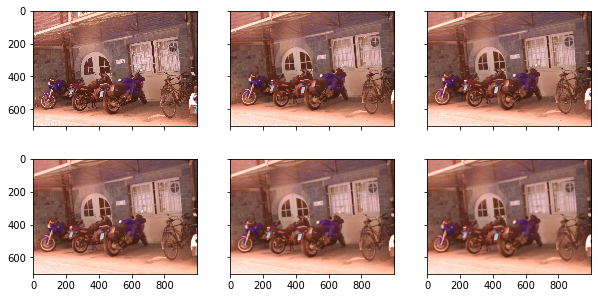

In [6]:
# all_detectors = dd.get_all_detectors()
# print(list(all_detectors.keys()))
image_set = util.get_image_set(pckl_path, 'bikes')
util.show_image_set(image_set)

### First experiment
Visualize total number of keypoints vs execution time for corresponding detectors

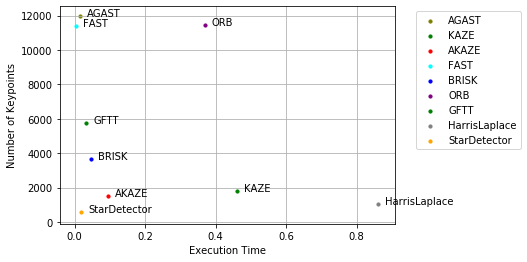

In [7]:
image_set_ = util.get_image_set(pckl_path, 'bikes')
image_num = 1
image = image_set_['{0}_img{1}'.format('bikes', image_num)]
ex.experiment_1_plt(image)

Number of total keypoints and execution time for each detector type for an image

In [8]:
image_set_name = 'bikes'
image_set_ = util.get_image_set(pckl_path, image_set_name)
image_num = 4
image = image_set_['{0}_img{1}'.format(image_set_name, image_num)]
df = ex.experiment_1_df(image)
df.style. \
    apply(util.highlight_max, subset=['Execution Time', 'Number of Keypoints']). \
    apply(util.highlight_min, subset=['Execution Time', 'Number of Keypoints'])


,Detector,Execution Time,Number of Keypoints
0,AGAST,0.005615,1115
1,KAZE,0.450426,928
2,AKAZE,0.098620,970
3,FAST,0.001179,1039
4,BRISK,0.015796,561
5,ORB,0.006286,2196
6,GFTT,0.031860,8020
7,HarrisLaplace,0.857324,376
8,StarDetector,0.018706,175


#### Visualize average total number of keypoints vs average execution time for corresponding detectors for a certain image set

In [9]:
image_set_arr = ['leuven', 'bikes', 'ubc']
plot_data_arr = []

for image_set_name in image_set_arr: 
    image_set = util.get_image_set(pckl_path, image_set_name)
    avg_execution_time, avg_total_keypoints = ip.get_det_avg_numkp_et(image_set)
    plot_data = {}
    for name in avg_execution_time.keys():
        plot_data[name] = [avg_execution_time[name], avg_total_keypoints[name]]
    plot_data_arr.append(plot_data)

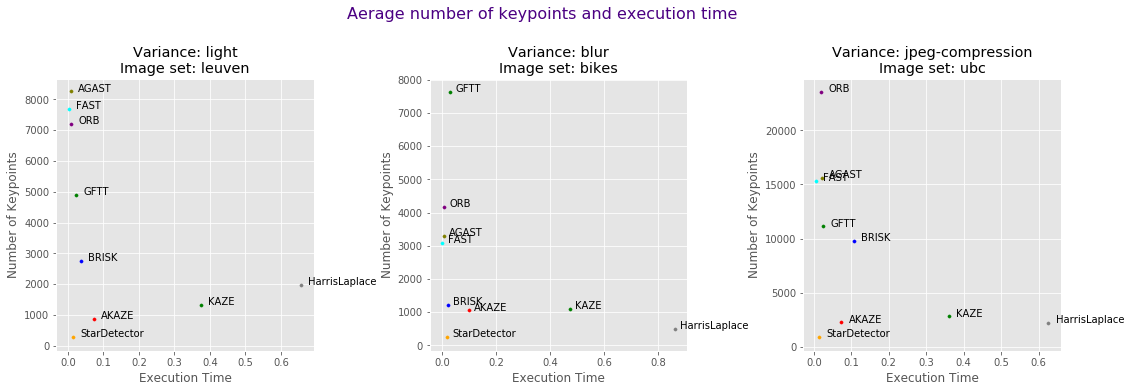

In [10]:
# sns.set_style("darkgrid")
plt.style.use('ggplot')

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
colors = ['olive', 'green', 'red', 'cyan', 'blue', 'purple', 'green', 'grey', 'orange', 'brown']

plot_data_index = 0
for plot_data in plot_data_arr:
    color_index = 0
    for key, values in plot_data.items():
        x, y = values
        axs[plot_data_index].scatter(x, y, c=colors[color_index], s=10, label=key)
        axs[plot_data_index].annotate(key, xy=(x+0.02, y), textcoords='data')
        color_index += 1
    axs[plot_data_index].grid(True)
    # axs[1].legend(loc="upper center",bbox_to_anchor=(0.5, -0.15), ncol=3)
    axs[plot_data_index].set_xlabel("Execution Time")
    axs[plot_data_index].set_ylabel("Number of Keypoints")
    variance = image_set_variance[image_set_arr[plot_data_index]]
    image_set_name = image_set_arr[plot_data_index]
    axs[plot_data_index].set_title(f"Variance: {variance}\nImage set: {image_set_name}")
    plot_data_index += 1
fig.subplots_adjust(wspace = 0.45)
plt.suptitle('Aerage number of keypoints and execution time', fontsize = 16, y = 1.08, color='indigo')
plt.show()

#### Gradual blurring
The runtime and number of keypoints detected as the image is progressively blurred
##### Observations:
- Harris Laplace has the highest runtime 0.85 seconds. KAZE has a runtime of ~0.45s and the rest falls wihtin a very close range ~0.001 to ~0.03 
- All the detectors trends downward while only GFTT detects more keypoints for the 'bikes' image set.

In [11]:
image_set_arr = ['leuven', 'trees', 'ubc']
plot_data_arr = []

for image_set_name in image_set_arr: 
    image_set = util.get_image_set(pckl_path, image_set_name)  
    plot_data = {}
    for detector_name in dd.get_all_detectors().keys():    
#     if detector_name in ['FAST', 'AGAST']:
#         continue
#         execution_time, total_keypoints 
        plot_data[detector_name]= ip.get_det_kp_et(image_set, detector_name)
    plot_data_arr.append(plot_data)
print(len(plot_data_arr))

3


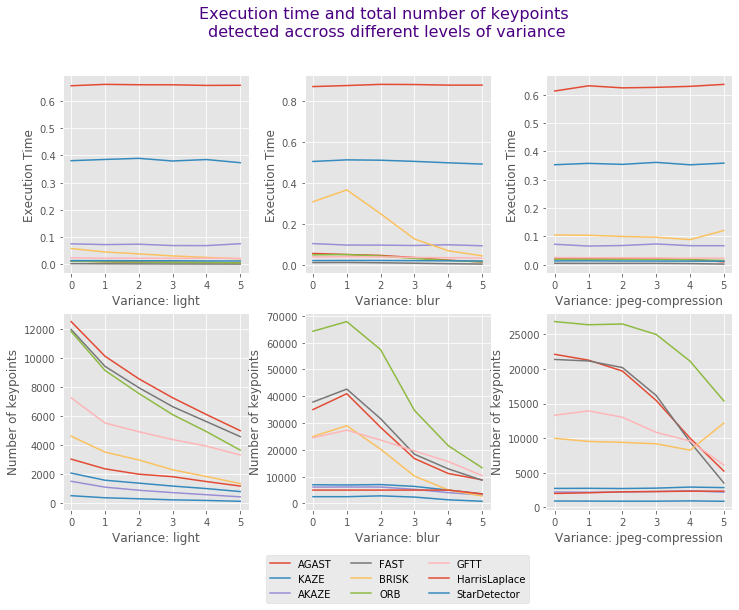

In [12]:
plt.style.use('ggplot')
fig, axs = plt.subplots(2, 3, figsize=(12,8))
axs_col = 0
for plot_data in plot_data_arr:
    for detector_name in dd.get_all_detectors().keys(): 
        execution_time, total_keypoints = plot_data[detector_name]
        axs[0, axs_col].plot(list(execution_time.keys()), list(execution_time.values()), label=detector_name)
        axs[1, axs_col].plot(list(total_keypoints.keys()), [len(value) for value in total_keypoints.values()], label=detector_name)
#     axs[0, axs_col].legend(loc="upper center",bbox_to_anchor=(0.5, -0.15), ncol=3)
    variance = image_set_variance[image_set_arr[axs_col]]
    axs[0, axs_col].set_xlabel(f'Variance: {variance}')
    axs[0, axs_col].set_ylabel("Execution Time")
    
#     axs[1, axs_col].legend(loc="upper center",bbox_to_anchor=(0.5, -0.15), ncol=3)
    axs[1, axs_col].set_xlabel(f'Variance: {variance}')
    axs[1, axs_col].set_ylabel("Number of keypoints")
    axs_col += 1
#     print(image_set_name)
handles, labels = axs[0, 0].get_legend_handles_labels()
plt.legend(handles, labels, loc="upper center",bbox_to_anchor=(-0.8, -0.2), ncol = 3)
fig.subplots_adjust(wspace = 0.3)
plt.suptitle('Execution time and total number of keypoints \ndetected accross different levels of variance', fontsize = 16, y = 1.0, color='indigo')
plt.show()

#### Gradual darkenning
__Todo__

- [ ] Change to bar plot
- [ ] Ask in stackoverflow about this checkbox problem

In [13]:
image_set_name = 'leuven'
image_set_ = util.get_image_set(pckl_path, image_set_name)
image_num = 4
image = image_set_['{0}_img{1}'.format(image_set_name, image_num)]
df = ex.experiment_1_df(image)
df.style. \
    apply(util.highlight_max, subset=['Execution Time', 'Number of Keypoints']). \
    apply(util.highlight_min, subset=['Execution Time', 'Number of Keypoints'])

,Detector,Execution Time,Number of Keypoints
0,AGAST,0.008367,7263
1,KAZE,0.358415,1174
2,AKAZE,0.072981,723
3,FAST,0.002255,6651
4,BRISK,0.032570,2298
5,ORB,0.008526,6100
6,GFTT,0.022996,4379
7,HarrisLaplace,0.660470,1821
8,StarDetector,0.014057,224


#### Use set to find the intersection of the keypoints to the union

In [80]:

image_set = util.get_image_set(pckl_path, 'bikes')
image = image_set['bikes_img1']

execution_time, total_keypoints = ip.get_alldet_kp_et(image)
# union_keypoints = set()
# union_keypoints.update(*total_keypoints.values())
# union_keypoints = *union_keypoints.pt
# print(len(all_keypoints))

__TODO__
- [ ] Find intersection
- [ ] Graph frequncy in seaborn
- [ ] List to numpy

In [16]:
from itertools import chain

kp_np_det = ip.cvkp2np(total_keypoints)
kp_np_unique = np.array(list(chain(*[value.tolist() for value in kp_np_det.values()])))
kp_np_unique= np.unique(kp_np_unique, axis=0,)
# print(kp_all.shape)
# print(kp_np.keys())

In [ ]:
# keypoint_list = list(union_keypoints)
# print(keypoint_list )
point_freq = np.zeros((kp_np_unique.shape[0],1))
for i in range(0, kp_np_unique.shape[0]):
    for detector in dd.get_all_detectors().keys():
        if kp_np_unique[i] in kp_np_det[detector]:
            point_freq[i] += 1
print(point_freq)

In [56]:
from itertools import chain

def get_kp_frequency(kp_np_det, kp_np_unique):
    
    point_freq = np.zeros((kp_np_unique.shape[0],1))
    for i in range(0, kp_np_unique.shape[0]):
        for detector in dd.get_all_detectors().keys():
            if kp_np_unique[i] in kp_np_det[detector]:
                point_freq[i] += 1
    kp_np_unique_freq = np.hstack((kp_np_unique, point_freq))
    return kp_np_unique_freq

In [ ]:
a = get_kp_frequency(total_keypoints)
a.shape

In [ ]:
frequency, counts = np.unique( point_freq, return_counts=True)
dict(zip(frequency, counts))

In [61]:
# print(kp_freq.shape)
# plt.imshow(image)
# plt.show()
def get_kp_filtered_frequency(kp_np_det, kp_np_unique, frequency):
    kp_freq = get_kp_frequency(kp_np_det, kp_np_unique)
    index_matched = np.where(kp_freq[:,2] == frequency)
    kp_filtered_frequency = kp_np_unique[index_matched]
    return kp_filtered_frequency

In [74]:
def get_matched_kp_ratio_det(kp_np_det, frequency):
    kp_np_unique= np.unique(np.array(list(chain(*[value.tolist() for value in kp_np_det.values()]))), axis=0,)
    kp_filtered_frequency = get_kp_filtered_frequency(kp_np_det, kp_np_unique, frequency)
#     print(kp_filtered_frequency)
    matched_kp_ratio_det = dict()
    total_unique_kp = kp_np_unique.shape[0]
    
    for detector, kp in kp_np_det.items():
        matched_kp_total = np.array([1 for kp_filtered in kp_filtered_frequency if kp_filtered in kp_np_det[detector]]).sum()
        matched_kp_ratio_det[detector] = matched_kp_total/total_unique_kp
    return matched_kp_ratio_det

In [ ]:
image_set = util.get_image_set(pckl_path, 'bikes')
image = image_set['bikes_img1']

execution_time, total_keypoints = ip.get_alldet_kp_et(image)

In [81]:
kp_np_det = ip.cvkp2np(total_keypoints)
frequencies = [1, 2, 3, 4, 5, 6, 7, 8, 9]
matched_kp_ratio_det_freq = dict()
for frequency in frequencies:
     matched_kp_ratio_det_freq[frequency]= get_matched_kp_ratio_det(kp_np_det, frequency)

In [82]:
plot_data = dict()
for detector in dd.get_all_detectors():
    plot_data_det = list()
    for frequency in matched_kp_ratio_det_freq.keys():
        plot_data_det.append(matched_kp_ratio_det_freq[frequency][detector])
    plot_data[detector] = np.array(plot_data_det)
    

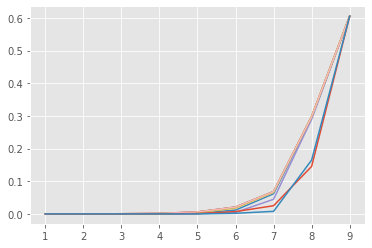

In [83]:
for detector, data in plot_data.items():
    plt.plot(frequencies, data)
plt.show()

In [ ]:
# plt.plot(range(0, len(point_freq)), point_freq)
# sns.relplot(x="total_bill", y="tip", data=[range(0, len(point_freq)), point_freq])
sns.set()
plt.scatter([x for (x,y) in keypoint_list], [700-y for (x,y) in keypoint_list], s=point_freq)
plt.show()